# Decision Trees using pipelines

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split

# Loading the data set

In this lecture, we will use the Abalone data set for classification.

Abalone is a type of consumable snail whose price varies as per its age. The aim is to predict the age of abalone from physical measurements.
The age of abalone is traditionally determined by cutting the shell through the cone, staining it, and counting the number of rings through a
microscope - a boring and time-consuming task. Other measurements, which are easier to obtain, are used to predict the age.

In [2]:
column_names = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
abalone_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data', header=None, names=column_names, sep=',')

### Examining Data Set

In [4]:
abalone_data.shape

(4177, 9)

In [5]:
abalone_data.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


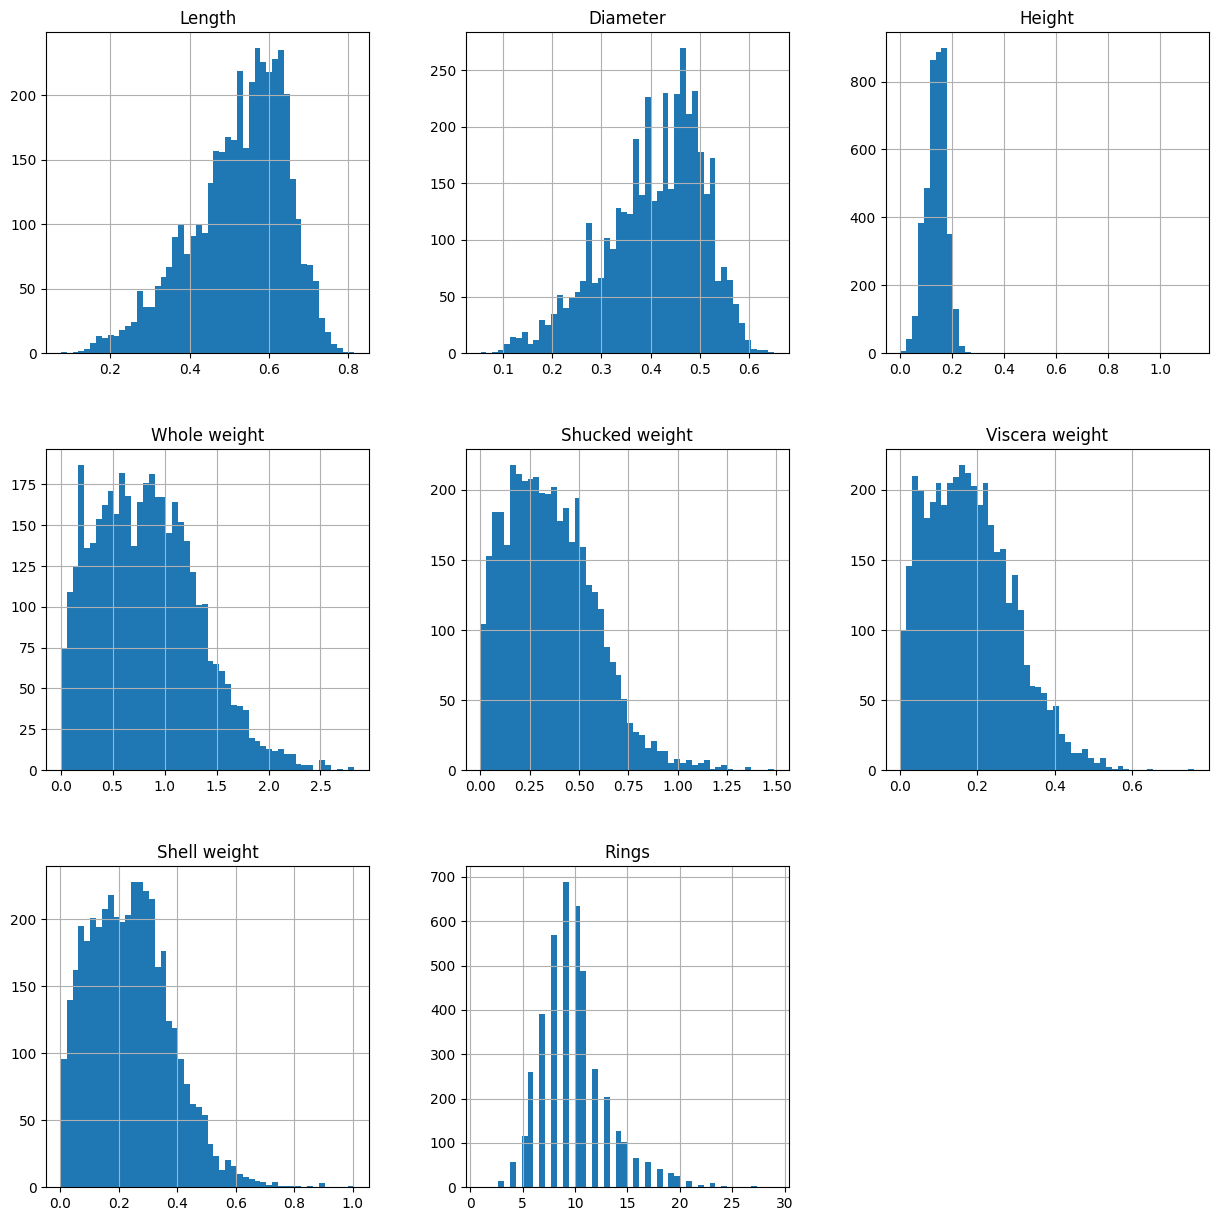

In [6]:
abalone_data.hist(bins=50, figsize=(15, 15))
plt.show()

<Figure size 640x480 with 0 Axes>

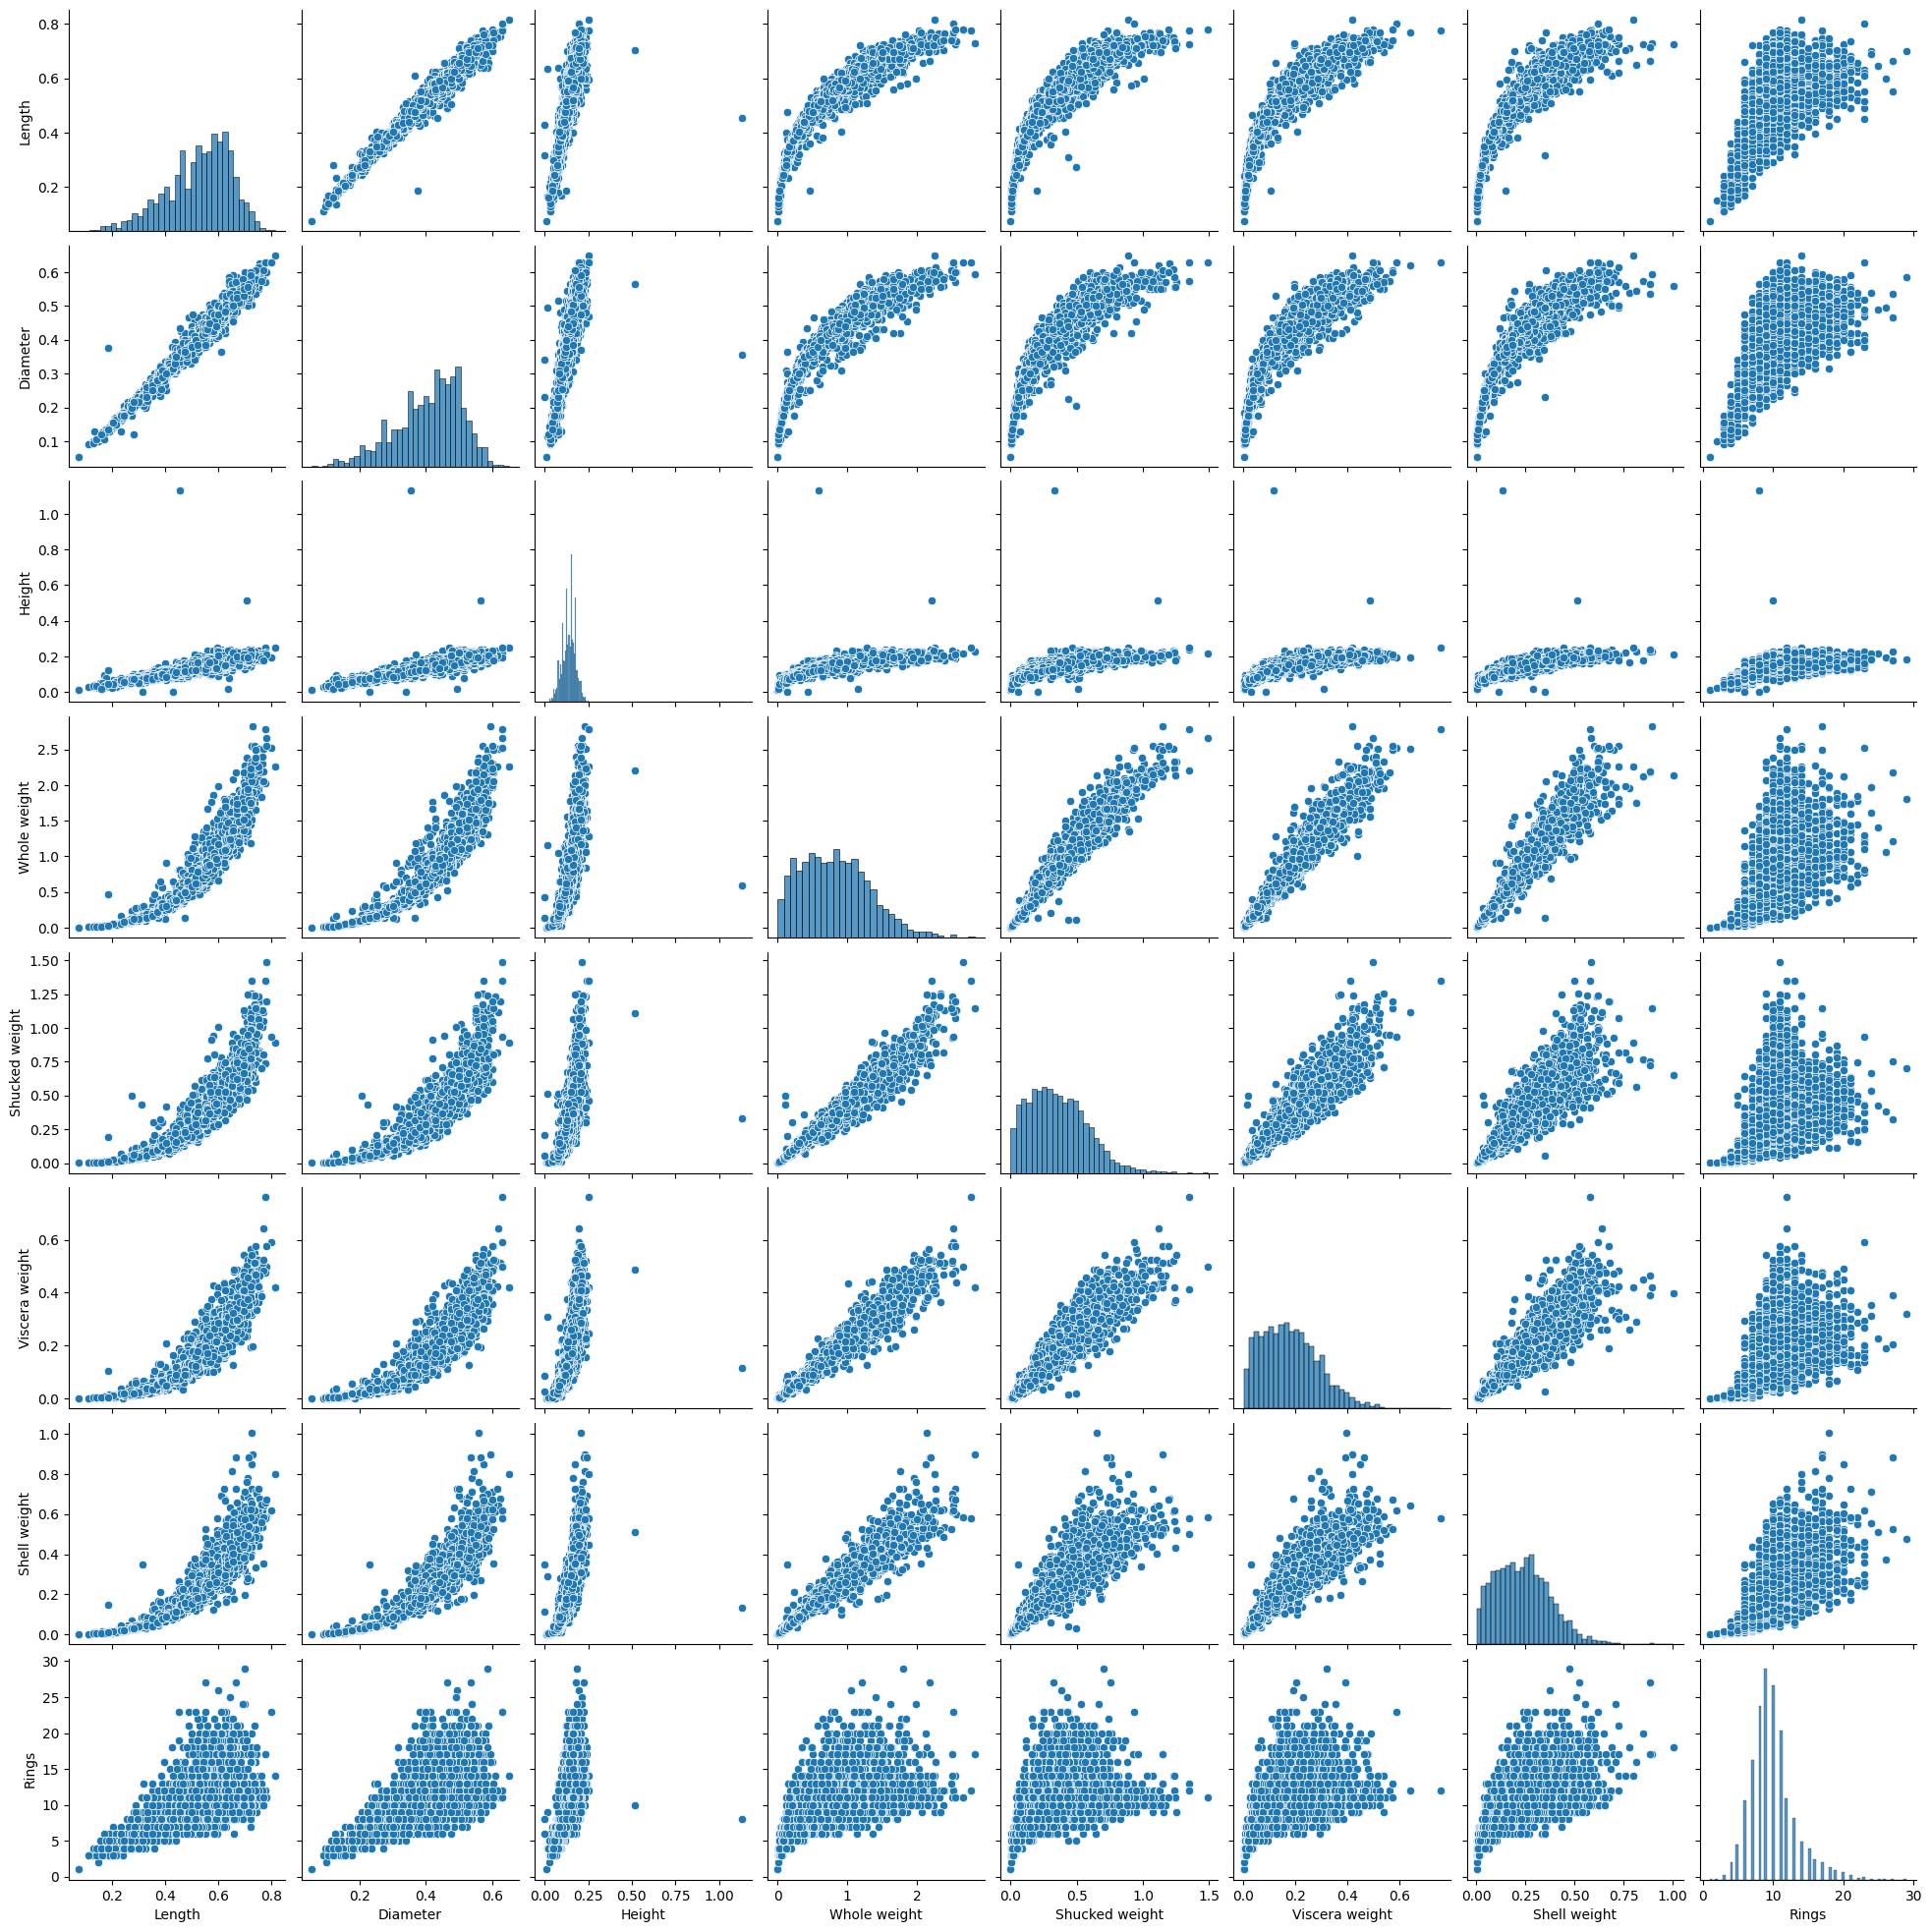

In [7]:
plt.figure()
sns.pairplot(abalone_data, diag_kind='hist')
plt.show()

In [11]:
abalone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


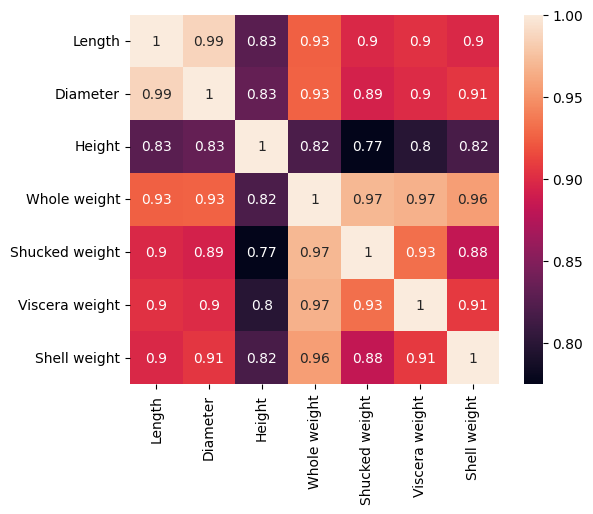

In [13]:
plt.figure()
sns.heatmap(abalone_data.iloc[:, 1:-1].corr(), annot=True, square=True)
plt.show()

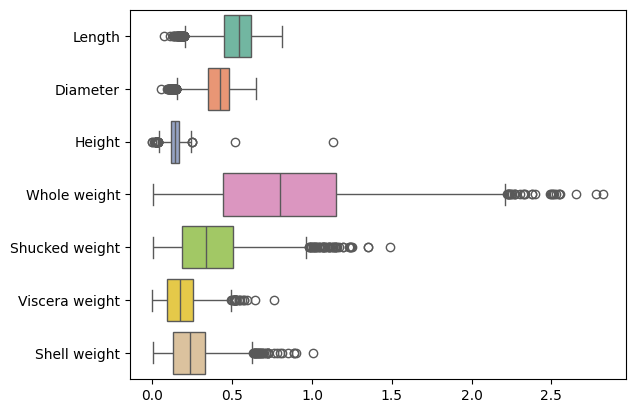

In [12]:
plt.figure()
sns.boxplot(data=abalone_data.iloc[:, 1:-1], orient='h', palette='Set2')
plt.show()

We find different features to be having different ranges through this box-plot, which **indicates that scaling the features may be useful**.

In [14]:
abalone_data.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000



- The count row shows that there are no missing values.

- However, in the Height feature, the minimum value is zero. This possibility calls for a missing value in the data and we will process the missing
value.


- Next, take a look at the target in this case in the Rings column

In [15]:
abalone_data['Rings' ].unique()

array([15,  7,  9, 10,  8, 20, 16, 19, 14, 11, 12, 18, 13,  5,  4,  6, 21,
       17, 22,  1,  3, 26, 23, 29,  2, 27, 25, 24], dtype=int64)

In [16]:
abalone_data['Rings' ].value_counts().sort_index()

Rings
1       1
2       1
3      15
4      57
5     115
6     259
7     391
8     568
9     689
10    634
11    487
12    267
13    203
14    126
15    103
16     67
17     58
18     42
19     32
20     26
21     14
22      6
23      9
24      2
25      1
26      1
27      2
29      1
Name: count, dtype: int64

# Missing values (or 0 values)
We first check how many missing values are in the Height feature and which class is it in.

In [17]:
(abalone_data['Height'] == 0).sum()

2

In [18]:
abalone_data[abalone_data['Height'] == 0]

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6


The number of missing values is 2 and is in the infant sex. Then we change the value 0 to null. We will fill in the missing value with the average
Height feature for the infant gender

In [19]:
means = pd.pivot_table(abalone_data, index = ['Sex'], aggfunc = {'Height':np.mean})
means

C:\Users\91820\AppData\Local\Temp\ipykernel_15648\3873427106.py:1: FutureWarning: The provided callable <function mean at 0x000002875D118550> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  means = pd.pivot_table(abalone_data, index = ['Sex'], aggfunc = {'Height':np.mean})


,Height
Sex,
F,0.158011
I,0.107996
M,0.151381


### Sorting

In [20]:
X = abalone_data.iloc[:, :-1]
y = abalone_data.iloc[:, -1]

### Splitting data into train and test sets

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Pipelining
We will use pipelines to perform preprocessing of the data, which will include: handling missing (or 0) values, scaling the features and handling
the categorical feature (viz., sex in this case)

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

In [23]:
numeric_features = ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']
categorical_features = ["Sex"]

In [24]:
numeric_transformer = Pipeline(
    steps=[
        (
            "imputer",
            SimpleImputer(missing_values=0, strategy="constant", fill_value=0.107996),
        ),
        ("scaler", StandardScaler()),
    ]
)

In [25]:
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

In [26]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [27]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", DecisionTreeClassifier(max_depth=3, random_state=42)),
    ]
)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.245


In [28]:
y_pred = clf.predict(X_test)

In [30]:
comparison = np.concatenate((y_pred.reshape(len(y_pred),1), y_test.values.reshape(len(y_test),1)), 1)

for each in comparison:
    print (each)

[10 13]
[8 8]
[10 11]
[4 5]
[10 12]
[10 11]
[9 7]
[8 8]
[7 7]
[10  9]
[7 8]
[5 8]
[ 9 11]
[8 9]
[5 4]
[10  7]
[9 7]
[10 17]
[10  7]
[7 7]
[7 7]
[7 5]
[8 8]
[9 9]
[10 10]
[10 10]
[4 5]
[11 15]
[ 8 10]
[10 14]
[9 8]
[4 4]
[10  9]
[11 13]
[7 7]
[8 7]
[7 8]
[10  9]
[7 8]
[10 11]
[ 8 15]
[ 8 12]
[ 8 17]
[10 16]
[10 11]
[ 8 11]
[9 8]
[10 10]
[10 11]
[7 6]
[10 13]
[7 7]
[ 9 13]
[11 20]
[ 8 12]
[9 7]
[5 8]
[ 9 10]
[7 7]
[7 7]
[10  9]
[9 9]
[ 9 11]
[7 8]
[7 7]
[11 12]
[11 13]
[10 17]
[8 8]
[11 12]
[8 9]
[11 17]
[10 10]
[8 6]
[ 8 11]
[8 8]
[10  8]
[8 9]
[10  8]
[8 8]
[10  8]
[5 6]
[7 7]
[10 13]
[ 8 11]
[7 6]
[10  9]
[11 12]
[4 5]
[7 6]
[ 9 11]
[ 8 11]
[9 8]
[7 7]
[10 16]
[5 8]
[ 8 11]
[9 8]
[10 18]
[10 11]
[10 12]
[ 8 14]
[10 12]
[10 11]
[5 6]
[10  9]
[7 7]
[7 6]
[ 7 11]
[10 11]
[11 11]
[11 12]
[ 8 20]
[ 9 10]
[10 14]
[11 10]
[10 10]
[10 12]
[5 4]
[ 8 12]
[7 7]
[10 13]
[7 6]
[8 8]
[10 17]
[10 15]
[10  9]
[10 11]
[7 7]
[10 11]
[10  8]
[9 7]
[8 7]
[10 10]
[11 11]
[10  9]
[ 8 10]
[8 9]
[7 8]
[11 16

In [31]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  5  5  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  7 14  0 10  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1 12  0 28  4  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  3  0 56 13 22  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  0 25 43 28 13  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  7 47 24 47  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  4 22 17 49 15  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2 20 14 45 14  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1 17  3 30 15  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  8  2 18 10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 12  0 11  3  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  1  8  5  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  4  0  5  4  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  5  4  0  0

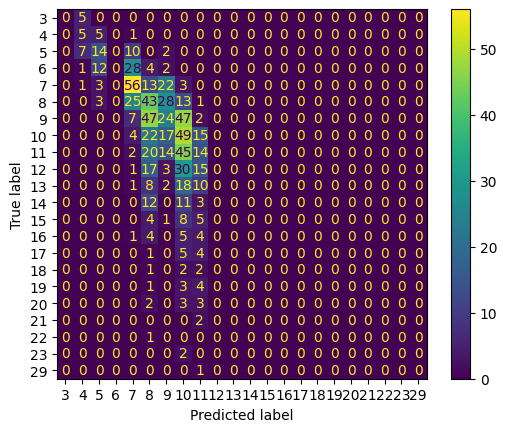

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay

y_test_predicted = clf.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_predicted)
plt.show()

In [34]:
from sklearn.metrics import classification_report

CR = classification_report(y_test, y_pred)
print(CR)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.26      0.45      0.33        11
           5       0.38      0.42      0.40        33
           6       0.00      0.00      0.00        47
           7       0.41      0.57      0.48        98
           8       0.21      0.38      0.27       113
           9       0.21      0.19      0.20       127
          10       0.20      0.46      0.28       107
          11       0.16      0.15      0.16        95
          12       0.00      0.00      0.00        66
          13       0.00      0.00      0.00        39
          14       0.00      0.00      0.00        26
          15       0.00      0.00      0.00        18
          16       0.00      0.00      0.00        14
          17       0.00      0.00      0.00        10
          18       0.00      0.00      0.00         5
          19       0.00      0.00      0.00         8
          20       0.00    

c:\Users\91820\Desktop\MLP-IIT\.env\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\91820\Desktop\MLP-IIT\.env\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\91820\Desktop\MLP-IIT\.env\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Cross-validation

In [36]:
from sklearn.model_selection import cross_val_score
acc = cross_val_score(estimator = clf, X = X_train, y = y_train, cv = 10)
print(type(acc))
print('Accuracy of each fold ', list(acc*100))
print("Accuracy: {:.2f} %".format(acc.mean()*100) )

c:\Users\91820\Desktop\MLP-IIT\.env\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


<class 'numpy.ndarray'>
Accuracy of each fold  [27.46268656716418, 22.45508982035928, 23.952095808383234, 24.550898203592812, 24.251497005988025, 23.952095808383234, 25.449101796407188, 30.83832335329341, 26.34730538922156, 26.047904191616766]
Accuracy: 25.53 %


### Visualizing the decision tree

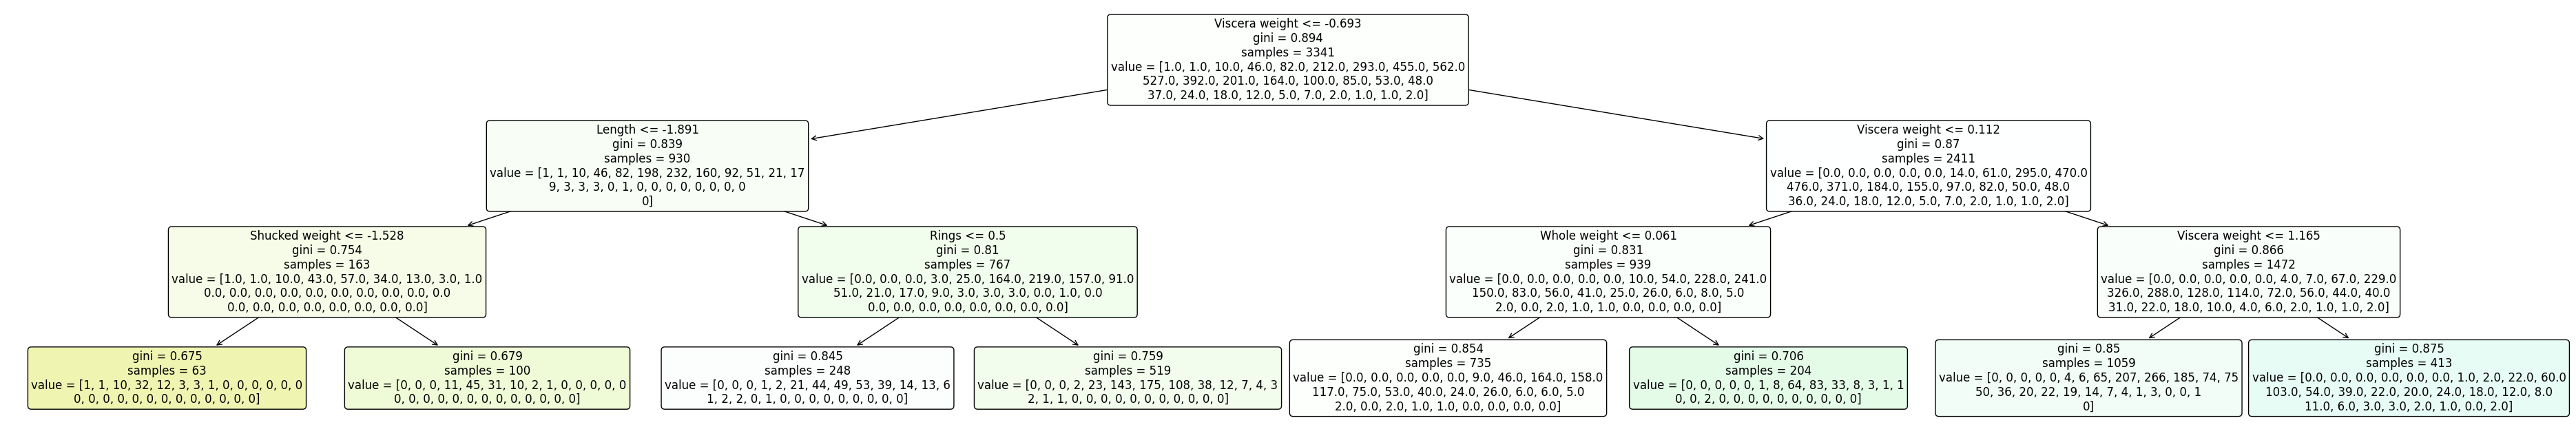

In [37]:
from sklearn import tree

# plt the figure, setting a black background
plt.figure(figsize=(48, 8), facecolor="w")

# create the tree plot
a = tree.plot_tree(
    clf["classifier"],
    # use the feature names stored
    feature_names=column_names,
    rounded=True,
    filled=True,
    fontsize=12,
)

# show the plot
plt.show()

# Finding the best parameters using GridSearchCV

In [38]:
X_train_new = preprocessor.fit_transform(X_train)

In [40]:
import warnings
warnings.filterwarnings("ignore")

In [41]:
from sklearn.model_selection import GridSearchCV

tuned_parameters = [
    {"max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9], "min_samples_split": [2, 4, 6, 8, 10]}
]

scores = ["recall"]
for score in scores:

    print()
    print(f"Tuning hyperparameters for {score}")
    print()

    clf_CV = GridSearchCV(
        DecisionTreeClassifier(), tuned_parameters, scoring=f"{score}_macro"
    )

    clf_CV.fit(X_train_new, y_train)

    print("Best parameters:")
    print()
    print(clf_CV.best_params_)
    print()
    print("Grid scores:")
    means = clf_CV.cv_results_["mean_test_score"]
    stds = clf_CV.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf_CV.cv_results_["params"]):
        print(f"{mean: 0.3f} (+/-{std*2:0.03f}) for {params}")


Tuning hyperparameters for recall

Best parameters:

{'max_depth': 5, 'min_samples_split': 4}

Grid scores:
 0.073 (+/-0.009) for {'max_depth': 1, 'min_samples_split': 2}
 0.073 (+/-0.009) for {'max_depth': 1, 'min_samples_split': 4}
 0.073 (+/-0.009) for {'max_depth': 1, 'min_samples_split': 6}
 0.073 (+/-0.009) for {'max_depth': 1, 'min_samples_split': 8}
 0.073 (+/-0.009) for {'max_depth': 1, 'min_samples_split': 10}
 0.107 (+/-0.011) for {'max_depth': 2, 'min_samples_split': 2}
 0.107 (+/-0.011) for {'max_depth': 2, 'min_samples_split': 4}
 0.107 (+/-0.011) for {'max_depth': 2, 'min_samples_split': 6}
 0.107 (+/-0.011) for {'max_depth': 2, 'min_samples_split': 8}
 0.107 (+/-0.011) for {'max_depth': 2, 'min_samples_split': 10}
 0.131 (+/-0.012) for {'max_depth': 3, 'min_samples_split': 2}
 0.131 (+/-0.012) for {'max_depth': 3, 'min_samples_split': 4}
 0.131 (+/-0.012) for {'max_depth': 3, 'min_samples_split': 6}
 0.131 (+/-0.012) for {'max_depth': 3, 'min_samples_split': 8}
 0.131 

Let us now create a new pipeline using the best features identified above.

In [42]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf2 = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            DecisionTreeClassifier(max_depth=5, min_samples_split=4, random_state=42),
        ),
    ]
)

In [43]:
clf2.fit(X_train, y_train)
print("model score: %.3f" % clf2.score(X_test, y_test))

model score: 0.272
